<a href="https://colab.research.google.com/github/thaivo02/Sentiment-analysis/blob/main/Sentiment_analysis_to_predict_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download files

In [1]:
!pip install nltk
!pip install underthesea
!pip install transformers torch
!pip install SentencePiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 35.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylin

In [ ]:
!wget https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt

--2024-06-27 08:21:40--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘vietnamese-stopwords.txt.1’

vietnamese-stopword 100%[===================>]  20.00K  --.-KB/s    in 0.006s  

2024-06-27 08:21:41 (3.28 MB/s) - ‘vietnamese-stopwords.txt.1’ saved [20475/20475]



In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/f/f2/Logo_Twitter.png

--2024-06-27 08:21:42--  https://upload.wikimedia.org/wikipedia/commons/f/f2/Logo_Twitter.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20270 (20K) [image/png]
Saving to: ‘Logo_Twitter.png.1’

Logo_Twitter.png.1  100%[===================>]  19.79K  --.-KB/s    in 0.03s   

2024-06-27 08:21:43 (616 KB/s) - ‘Logo_Twitter.png.1’ saved [20270/20270]



# Import libraries

In [2]:
import nltk
import math
import string
import re
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import underthesea
from underthesea import word_tokenize
from underthesea import text_normalize
from datetime import datetime
import timeit
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [3]:
import torch
from transformers import RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Prepare data

In [82]:
company_list = ['API', 'AGG', 'BID', 'FPT', 'VCB', 'ACV', 'OIL', 'ABB', 'ABC']

## Call API to get data

In [131]:
fromDate = '01/01/2024'
toDate = '27/06/2024'

### Crawl data from CafeF

In [136]:
headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 OPR/109.0.0.0"}

In [135]:
cafef_news = {}

In [144]:
for company in company_list:
    index = 1
    finished = False
    cafef_news[company] = {}
    cafef_news[company]['news'] = []
    cafef_news[company]['timeline'] = []
    while not finished:
        url = f"https://s.cafef.vn/Ajax/Events_RelatedNews_New.aspx?symbol={company}&floorID=0&configID=0&PageIndex={index}&PageSize=30&Type=2"
        response = requests.get(url, headers = headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            titles = soup.find_all("a", class_="docnhanhTitle")
            titles = [title.text.strip().split(": ")[-1] for title in titles]
            timeline = soup.find_all("span", class_="timeTitle")
            timeline = [time.text.strip().split(' ')[0] for time in timeline]
            if len(cafef_news[company]['news']) == 0:
                cafef_news[company]['news'] = titles
                cafef_news[company]['timeline'] = timeline
            else:
                cafef_news[company]['news'].extend(titles)
                cafef_news[company]['timeline'].extend(timeline)
            print(f"Fetched data for {company} - page: {index}")
        else:
            print(f"Failed to fetch data for {company}")
        if datetime.strptime(timeline[-1], "%d/%m/%Y") <= datetime.strptime(fromDate, "%d/%m/%Y"):
            finished = True
        else:
            index += 1

Fetched data for API - page: 1
Fetched data for AGG - page: 1
Fetched data for AGG - page: 2
Fetched data for BID - page: 1
Fetched data for BID - page: 2
Fetched data for FPT - page: 1
Fetched data for FPT - page: 2
Fetched data for FPT - page: 3
Fetched data for VCB - page: 1
Fetched data for ACV - page: 1
Fetched data for OIL - page: 1
Fetched data for ABB - page: 1
Fetched data for ABB - page: 2
Fetched data for ABC - page: 1


In [145]:
for company in company_list:
    company_date = list(cafef_news[company]['timeline'])
    cafef_news[company]['price'] = []
    startDate = company_date[-1]
    startDate = datetime.strptime(startDate, "%d/%m/%Y")
    startDate = startDate.strftime("%m/%d/%Y")
    endDate = company_date[0]
    endDate = datetime.strptime(endDate, "%d/%m/%Y")
    endDate = endDate.strftime("%m/%d/%Y")
    finished = False
    index = 1
    while not finished:
      url = f"https://s.cafef.vn/Ajax/PageNew/DataHistory/PriceHistory.ashx?Symbol={company}&StartDate={startDate}&EndDate={endDate}&PageIndex={index}"
      response = requests.get(url)
      if response.status_code == 200:
        data = response.json()
        if 'Data' in data:
            data = data['Data']['Data']
            for date in company_date:
                for item in data:
                    if item['Ngay'] == date:
                        cafef_news[company]['price'].append(float(item['GiaDongCua']))
      else:
        print(f"Failed to fetch price data for {company}")
      if len(data) == 0:
        finished = True
      elif datetime.strptime(data[-1]['Ngay'], "%d/%m/%Y") <= datetime.strptime(company_date[-1], "%d/%m/%Y"):
        finished = True
      else:
        index += 1
    price_len = len(cafef_news[company]['price'])
    date_len = len(company_date)
    if price_len < date_len:
        last_price = cafef_news[company]['price'][-1] if price_len > 0 else 0
        cafef_news[company]['price'].extend([last_price] * (date_len - price_len))

In [146]:
for company in company_list:
    print(f"{company}: {cafef_news[company]['news']}")
    print(f"Price: {(cafef_news[company]['price'])}")
    print(f"Number of price: {len(cafef_news[company]['price'])}")
    print(f"Time line: {cafef_news[company]['timeline']}")
    print(f"Number of news: {len(cafef_news[company]['news'])}")

API: ['Cổ phiếu “họ” Apec đồng loạt quay xe chóng vánh, nhà đầu tư lỡ đua lệnh giá trần tạm lỗ gần 20%', 'Thay đổi giấy ĐKKD do đổi người đại diện pháp luật', 'Giải trình giá cổ phiếu tăng trần 5 phiên liên tiếp', "Cổ phiếu 'họ Apec' tăng trần phiên thứ ba sau sự xuất hiện bất ngờ của ông Nguyễn Đỗ Lăng", 'Nghị quyết HĐQT thống nhất ông Nguyễn Đức Quân làm Chủ tịch HĐQT', 'Con gái sinh năm 2001 của ông Nguyễn Đỗ Lăng trở thành lãnh đạo cấp cao tại APEC Investment (API )', 'Ông Nguyễn Đức Quân làm Chủ tịch HĐQT, bà Nguyễn Thị Ngọc Hà làm Trưởng BKS từ 13.5.2024', 'Nghị quyết ĐHCĐ thường niên năm 2024', 'Biện pháp, lộ trình khắc phục chứng khoán bị cảnh báo', 'Công ty "họ APEC" API kinh doanh ra sao sau vụ thao túng chứng khoán đình đám khiến chủ tịch vướng lao lý?', 'Báo cáo thường niên 2023', '10.5.2024, tổ chức ĐHCĐ thường niên năm 2024', 'Bổ sung lý do cổ phiếu không được phép giao dịch ký quỹ', 'Cổ phiếu bị cảnh báo từ 9.4.2024', 'Giải trình liên quan đến BCTC năm 2023', 'Đơn từ nhi

### Crawl data from VietStock

In [147]:
headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 OPR/109.0.0.0",
    "Content-Type": "application/x-www-form-urlencoded"
}

In [148]:
url = 'https://finance.vietstock.vn/View/PagingNewsContent'

In [149]:
vietstock_news = {}

In [150]:
for company in company_list:
    index = 1
    max_index = 2
    finished = False
    vietstock_news[company] = {}
    vietstock_news[company]['news'] = []
    vietstock_news[company]['timeline'] = []
    while not finished:
        data = {
            'view': '1',
            'code': company,
            'type': '1',
            'fromDate': fromDate,
            'toDate': toDate,
            'channelID': '-1',
            'page': index,
            'pageSize': '20'
        }
        response = requests.post(url, headers = headers, data = data)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            total_pages = soup.find_all("div", class_="m-b pull-left")
            total_pages = int(total_pages[-1].text.split(' ')[-1])
            max_index = total_pages
            titles = soup.find_all("a", class_="text-link news-link")
            titles = [title.text.strip().split(": ")[-1] for title in titles]
            timeline = soup.find_all("td", class_="col-date")
            timeline = [time.text.strip().split(' ')[0] for time in timeline]
            if len(vietstock_news[company]['news']) == 0:
                vietstock_news[company]['news'] = titles
                vietstock_news[company]['timeline'] = timeline
            else:
                vietstock_news[company]['news'].extend(titles)
                vietstock_news[company]['timeline'].extend(timeline)
            print(f"Fetched data for {company} - page: {index}")
        else:
            print(f"Failed to fetch data for {company}")
        if index == max_index:
            finished = True
        else:
            index += 1

Fetched data for API - page: 1
Fetched data for API - page: 2
Fetched data for AGG - page: 1
Fetched data for AGG - page: 2
Fetched data for AGG - page: 3
Fetched data for BID - page: 1
Fetched data for BID - page: 2
Fetched data for BID - page: 3
Fetched data for BID - page: 4
Fetched data for BID - page: 5
Fetched data for BID - page: 6
Fetched data for BID - page: 7
Fetched data for BID - page: 8
Fetched data for FPT - page: 1
Fetched data for FPT - page: 2
Fetched data for FPT - page: 3
Fetched data for FPT - page: 4
Fetched data for FPT - page: 5
Fetched data for FPT - page: 6
Fetched data for VCB - page: 1
Fetched data for VCB - page: 2
Fetched data for VCB - page: 3
Fetched data for VCB - page: 4
Fetched data for VCB - page: 5
Fetched data for VCB - page: 6
Fetched data for ACV - page: 1
Fetched data for ACV - page: 2
Fetched data for OIL - page: 1
Fetched data for OIL - page: 2
Fetched data for ABB - page: 1
Fetched data for ABB - page: 2
Fetched data for ABB - page: 3
Fetched 

In [159]:
for company in company_list:
    company_date = list(vietstock_news[company]['timeline'])
    vietstock_news[company]['price'] = []
    startDate = company_date[-1]
    startDate = datetime.strptime(startDate, "%d/%m/%Y")
    startDate = startDate.strftime("%m/%d/%Y")
    endDate = company_date[0]
    endDate = datetime.strptime(endDate, "%d/%m/%Y")
    endDate = endDate.strftime("%m/%d/%Y")
    finished = False
    index = 1
    while not finished:
      url = f"https://s.cafef.vn/Ajax/PageNew/DataHistory/PriceHistory.ashx?Symbol={company}&StartDate={startDate}&EndDate={endDate}&PageIndex={index}"
      response = requests.get(url)
      if response.status_code == 200:
        data = response.json()
        if 'Data' in data:
            data = data['Data']['Data']
            for date in company_date:
                for item in data:
                    if item['Ngay'] == date:
                        vietstock_news[company]['price'].append(float(item['GiaDongCua']))
      else:
        print(f"Failed to fetch price data for {company}")
      if len(data) == 0:
        finished = True
      elif datetime.strptime(data[-1]['Ngay'], "%d/%m/%Y") <= datetime.strptime(company_date[-1], "%d/%m/%Y"):
        finished = True
      else:
        index += 1
    price_len = len(vietstock_news[company]['price'])
    date_len = len(company_date)
    if price_len < date_len:
        last_price = vietstock_news[company]['price'][-1] if price_len > 0 else 0
        vietstock_news[company]['price'].extend([last_price] * (date_len - price_len))

In [160]:
for company in company_list:
    print(f"{company}: {vietstock_news[company]['news']}")
    print(f"Price: {(vietstock_news[company]['price'])}")
    print(f"Number of price: {len(vietstock_news[company]['price'])}")
    print(f"Time line: {vietstock_news[company]['timeline']}")
    print(f"Number of news: {len(vietstock_news[company]['news'])}")

API: ['Doanh nghiệp bất động sản gia tăng vay nợ đầu năm 2024', 'Thay đổi giấy đăng ký kinh doanh', 'Cổ phiếu tăng 176% trong 1 tháng, API nói không có gì đặc biệt', 'CBTT giải trình về việc cổ phiếu API tăng trần 5 phiên liên tiếp', 'Thị trường bất động sản khởi sắc vẫn chưa đủ thấm vào kết quả kinh doanh quý 1', 'Apec Land Huế\xa0lỗ 19 tỷ đồng trong năm 2023', 'Cổ phiếu họ APEC có nhiều phiên tăng trần', 'Nghị quyết Hội đồng quản trị', 'Nghị quyết Đại hội đồng cổ đông thường niên năm 2024', 'Thông báo bổ nhiệm nhân sự, cán bộ cấp cao Công ty', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'CBTT tình trạng chứng khoán bị cảnh báo kèm theo biện pháp và lộ trình khắc phục.', 'Tài liệu họp Đại hội đồng cổ đông', 'Báo cáo thường niên 2023', 'Thông báo bổ sung lý do đưa cổ phiếu vào danh sách chứng khoán không được phép giao dịch ký quỹ', 'Quyết định chưa vào diện bị cảnh báo và tình trạng chứng khoán', 'Báo cáo tài chính năm 2023', 'Giải trình liên quan đến 

## Preprocess data

In [161]:
news_site = input("Chọn trang để phân tích dữ liệu: \n")
if (news_site.lower() == "cafef"):
  company_news = cafef_news
elif (news_site.lower() == "vietstock"):
  company_news = vietstock_news

Chọn trang để phân tích dữ liệu: 
vietstock


### Tokenize Vietnamese

In [162]:
stop_words = set()
with open('vietnamese-stopwords.txt', 'r') as f:
    for line in f:
        stop_words.add(line.strip())

In [163]:
def clean_text(text):
    text = text.lower() # lowercase text

    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')

    # Ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text) # reduce consecutive punctuation

    # Remove any leading or trailing spaces, or leading or trailing punctuation marks from the text
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuation

    text = re.sub(r"\s+", " ", text) # reduce multiple spaces

    text = text_normalize(text) # make sure punctunation is in the right letter (Vietnamese case)
    text = word_tokenize(text, format="text") # tokenize the cleaned text
    # text = unidecode(text) # remove accent marks from sentences (no significant difference when accent marks is removed or kept)

    text = text.split(' ')

    text = [word for word in text if word not in stop_words] # remove stop words

    text = ' '.join(text)
    return text

In [164]:
for company, item in company_news.items():
    company_news[company]['tokenized_news'] = []
    for title in item['news']:
        title = clean_text(title)
        company_news[company]['tokenized_news'].append(title)

In [165]:
for company in company_list:
    print(f"{company}: {company_news[company]['news']}")
    print(f"Tokenized news: {company_news[company]['tokenized_news']}")
    print(f"Number of news: {len(company_news[company]['news'])}")

API: ['Doanh nghiệp bất động sản gia tăng vay nợ đầu năm 2024', 'Thay đổi giấy đăng ký kinh doanh', 'Cổ phiếu tăng 176% trong 1 tháng, API nói không có gì đặc biệt', 'CBTT giải trình về việc cổ phiếu API tăng trần 5 phiên liên tiếp', 'Thị trường bất động sản khởi sắc vẫn chưa đủ thấm vào kết quả kinh doanh quý 1', 'Apec Land Huế\xa0lỗ 19 tỷ đồng trong năm 2023', 'Cổ phiếu họ APEC có nhiều phiên tăng trần', 'Nghị quyết Hội đồng quản trị', 'Nghị quyết Đại hội đồng cổ đông thường niên năm 2024', 'Thông báo bổ nhiệm nhân sự, cán bộ cấp cao Công ty', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'CBTT tình trạng chứng khoán bị cảnh báo kèm theo biện pháp và lộ trình khắc phục.', 'Tài liệu họp Đại hội đồng cổ đông', 'Báo cáo thường niên 2023', 'Thông báo bổ sung lý do đưa cổ phiếu vào danh sách chứng khoán không được phép giao dịch ký quỹ', 'Quyết định chưa vào diện bị cảnh báo và tình trạng chứng khoán', 'Báo cáo tài chính năm 2023', 'Giải trình liên quan đến 

### Plot word cloud

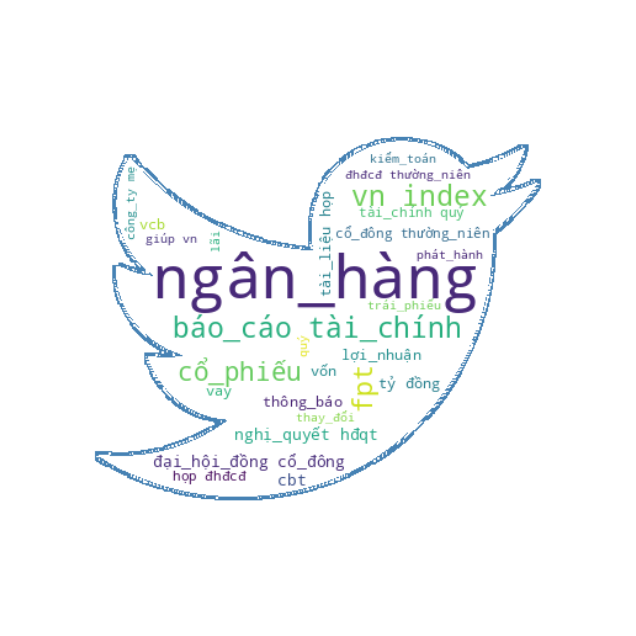

In [166]:
mask = np.array(Image.open('/content/Logo_Twitter.png'))

titles = []
for company, item in company_news.items():
    titles.extend(item['tokenized_news'])

titles = ' '.join(titles)

# Create WordCloud object
wordcloud = WordCloud(background_color='white',
                    mask=mask,
                    max_font_size=50,
                    contour_width=1,
                    contour_color='steelblue',
                    min_font_size=10)

# Generate word cloud
wordcloud.generate(titles)

# Plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Plot news length

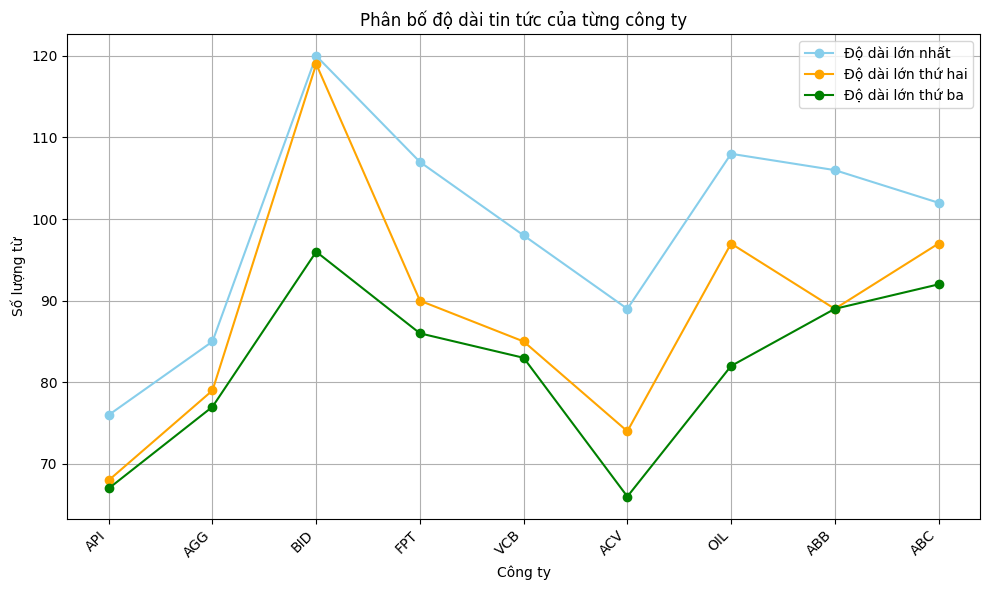

In [167]:
company_names = list(company_news.keys())
# Tạo danh sách chứa 3 độ dài dài nhất của tokenized_news cho mỗi công ty
top_lengths = []
for company in company_names:
    tokenized_news_lengths = [len(item) for item in company_news[company]['tokenized_news']]
    top_lengths.append(sorted(tokenized_news_lengths, reverse=True)[:3])

# Vẽ biểu đồ đường
plt.figure(figsize=(10, 6))

# Tạo mảng các index cho từng công ty
index = np.arange(1, len(company_names) + 1)

# Vẽ biểu đồ đường cho từng độ dài dài nhất
plt.plot(index, [max(lengths) for lengths in top_lengths], marker='o', linestyle='-', color='skyblue', label='Độ dài lớn nhất')
plt.plot(index, [sorted(lengths, reverse=True)[1] if len(lengths) > 1 else 0 for lengths in top_lengths], marker='o', linestyle='-', color='orange', label='Độ dài lớn thứ hai')
plt.plot(index, [sorted(lengths, reverse=True)[2] if len(lengths) > 2 else 0 for lengths in top_lengths], marker='o', linestyle='-', color='green', label='Độ dài lớn thứ ba')

plt.title('Phân bố độ dài tin tức của từng công ty')
plt.xlabel('Công ty')
plt.ylabel('Số lượng từ')
plt.xticks(index, company_names, rotation=45, ha='right')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Use models & libraries

## Use model VADER from NLTK

### Load model

In [168]:
analyzer = SentimentIntensityAnalyzer()

In [169]:
start = timeit.default_timer()

for company, item in company_news.items():
    company_news[company]['sentiment'] = []
    for title in item['tokenized_news']:
      sentiment = analyzer.polarity_scores(title)
      company_news[company]['sentiment'].append(sentiment['compound'])
      print(f"{company}: {title} - {sentiment}")

stop = timeit.default_timer()

vader_time_execution = stop - start

API: doanh_nghiệp bất_động_sản gia_tăng vay nợ đầu 2024 - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: thay_đổi giấy đăng_ký kinh_doanh - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: cổ_phiếu 176 1 api đặc_biệt - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: cbt giải_trình cổ_phiếu api trần 5 phiên liên_tiếp - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: thị_trường bất_động_sản khởi_sắc thấm kết_quả kinh_doanh quý 1 - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: apec land huế lỗ 19 tỷ đồng 2023 - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: cổ_phiếu apec phiên trần - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: nghị_quyết hội_đồng_quản_trị - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: nghị_quyết đại_hội_đồng cổ_đông thường_niên 2024 - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: thông_báo bổ_nhiệm nhân_sự cán_bộ công_ty - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'co

In [170]:
for company, item in company_news.items():
  print(f"{company}: {item}")
  print(f"Number of news: {len(item['news'])}")
  print(f"Number of timeline: {len(item['timeline'])}")
  print(f"Number of price: {len(item['price'])}")

API: {'news': ['Doanh nghiệp bất động sản gia tăng vay nợ đầu năm 2024', 'Thay đổi giấy đăng ký kinh doanh', 'Cổ phiếu tăng 176% trong 1 tháng, API nói không có gì đặc biệt', 'CBTT giải trình về việc cổ phiếu API tăng trần 5 phiên liên tiếp', 'Thị trường bất động sản khởi sắc vẫn chưa đủ thấm vào kết quả kinh doanh quý 1', 'Apec Land Huế\xa0lỗ 19 tỷ đồng trong năm 2023', 'Cổ phiếu họ APEC có nhiều phiên tăng trần', 'Nghị quyết Hội đồng quản trị', 'Nghị quyết Đại hội đồng cổ đông thường niên năm 2024', 'Thông báo bổ nhiệm nhân sự, cán bộ cấp cao Công ty', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'CBTT tình trạng chứng khoán bị cảnh báo kèm theo biện pháp và lộ trình khắc phục.', 'Tài liệu họp Đại hội đồng cổ đông', 'Báo cáo thường niên 2023', 'Thông báo bổ sung lý do đưa cổ phiếu vào danh sách chứng khoán không được phép giao dịch ký quỹ', 'Quyết định chưa vào diện bị cảnh báo và tình trạng chứng khoán', 'Báo cáo tài chính năm 2023', 'Giải trình liên 

In [171]:
stock_price = []
for company, item in company_news.items():
  stock_price.append(item['price'])

In [172]:
date_time = []
for company, item in company_news.items():
  date_time.append(item['timeline'])

### Plot sentiment score

In [194]:
vader_sentiment_scores = []

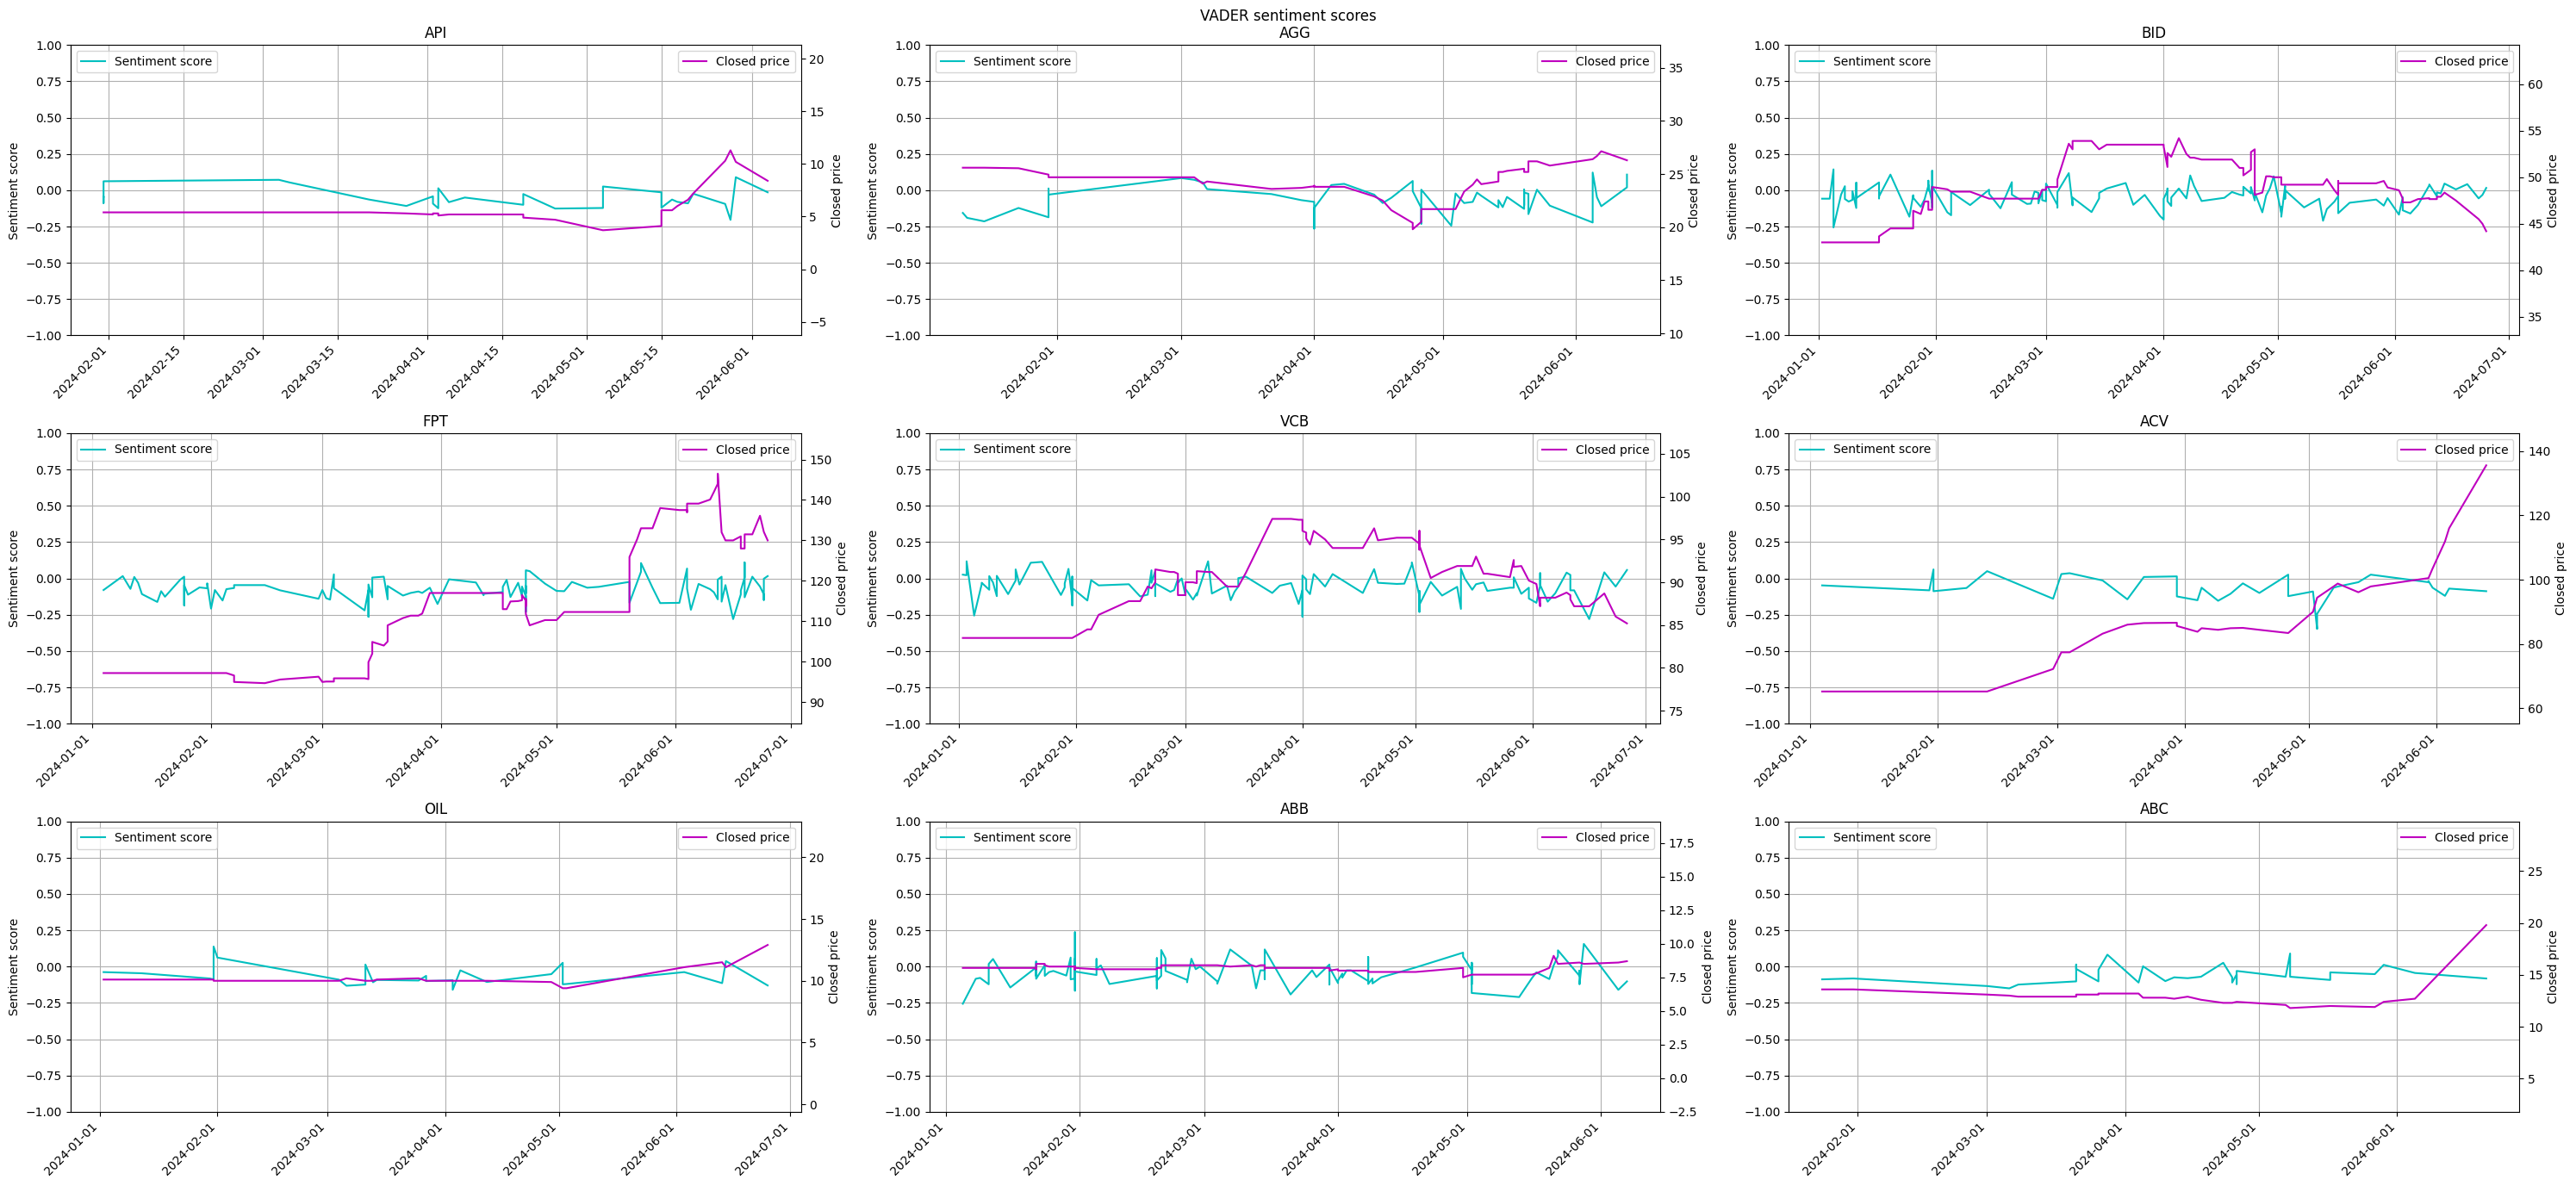

In [195]:
fig = plt.figure(figsize=(30, 14))

for company, item in company_news.items():
    date = item['timeline']
    price = item['price']
    sentiment_scores = item['sentiment']
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_title(company)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color='c', label='Sentiment score')
    ax.legend(loc='upper left')
    ax.set_ylabel('Sentiment score')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    axt = ax.twinx()
    axt.plot(dates, price, color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylabel('Closed price')

    axt.set_xlabel('Date')
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    vader_sentiment_scores.append(sentiment_scores)

fig.suptitle('VADER sentiment scores')
plt.legend()
plt.tight_layout()
plt.savefig('vader_sentiment_scores.png')
plt.show()

### Plot volatility

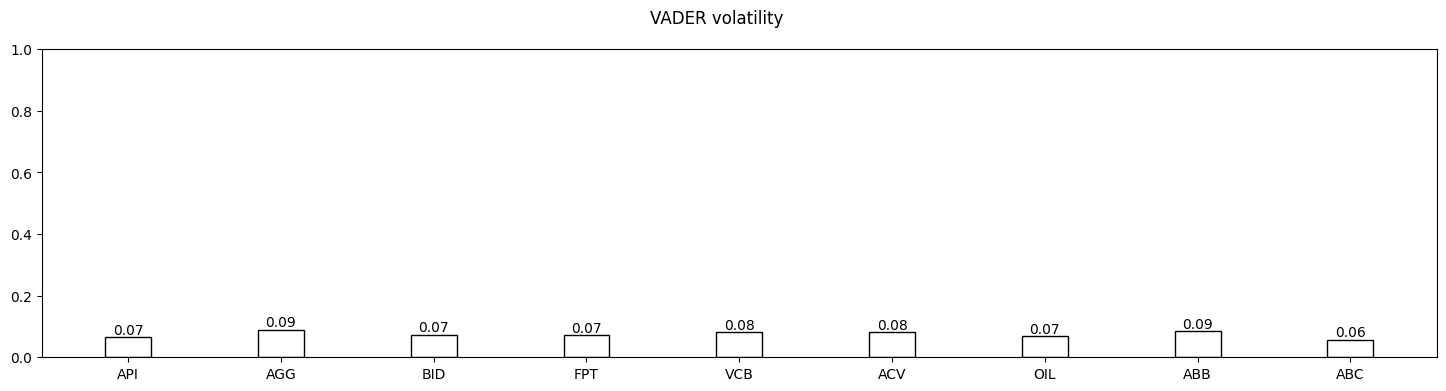

In [196]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = {}

for company, item in company_news.items():
    sentiment_scores = item['sentiment']
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(company_list.index(company), volatility, f"{volatility:.2f}", ha='center', va='bottom')

ax.bar(company_list, volatility_plot.values(), 0.3, color='w', edgecolor='k')
ax.set_ylim(0, 1)

fig.suptitle('VADER volatility')
plt.savefig('vader_volatility.png')
plt.show()

## Use PhoBERT pretrained model from Wonrax

### Load model

In [197]:
wonrax = RobertaForSequenceClassification.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

wonrax_tokenizer = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment", use_fast=False)

In [198]:
start = timeit.default_timer()

sentiments = {}

for company, item in company_news.items():
    company_news[company]['sentiment'] = []
    for title in item['tokenized_news']:
        input_ids = torch.tensor([wonrax_tokenizer.encode(title)])
        with torch.no_grad():
            out = wonrax(input_ids)
            sentiments['neg'] = round(out.logits.softmax(dim=-1).tolist()[-1][0], 3)
            sentiments['pos'] = round(out.logits.softmax(dim=-1).tolist()[-1][1], 3)
            sentiments['neu'] = round(out.logits.softmax(dim=-1).tolist()[-1][2], 3)
            sentiments['compound'] = round(sentiments['pos'] - sentiments['neg'], 4)
            company_news[company]['sentiment'].append(sentiments['compound'])
            print(f"{company}: {title} - {sentiments}")

stop = timeit.default_timer()

phobert_time_execution = stop - start

API: doanh_nghiệp bất_động_sản gia_tăng vay nợ đầu 2024 - {'neg': 0.029, 'pos': 0.256, 'neu': 0.715, 'compound': 0.227}
API: thay_đổi giấy đăng_ký kinh_doanh - {'neg': 0.362, 'pos': 0.048, 'neu': 0.59, 'compound': -0.314}
API: cổ_phiếu 176 1 api đặc_biệt - {'neg': 0.047, 'pos': 0.124, 'neu': 0.829, 'compound': 0.077}
API: cbt giải_trình cổ_phiếu api trần 5 phiên liên_tiếp - {'neg': 0.021, 'pos': 0.328, 'neu': 0.651, 'compound': 0.307}
API: thị_trường bất_động_sản khởi_sắc thấm kết_quả kinh_doanh quý 1 - {'neg': 0.002, 'pos': 0.973, 'neu': 0.025, 'compound': 0.971}
API: apec land huế lỗ 19 tỷ đồng 2023 - {'neg': 0.983, 'pos': 0.005, 'neu': 0.012, 'compound': -0.978}
API: cổ_phiếu apec phiên trần - {'neg': 0.018, 'pos': 0.324, 'neu': 0.658, 'compound': 0.306}
API: nghị_quyết hội_đồng_quản_trị - {'neg': 0.029, 'pos': 0.108, 'neu': 0.863, 'compound': 0.079}
API: nghị_quyết đại_hội_đồng cổ_đông thường_niên 2024 - {'neg': 0.013, 'pos': 0.674, 'neu': 0.313, 'compound': 0.661}
API: thông_báo b

In [199]:
for company, item in company_news.items():
  print(f"{company}: {item}")
  print(f"Number of news: {len(item['news'])}")
  print(f"Number of timeline: {len(item['timeline'])}")
  print(f"Number of price: {len(item['price'])}")

API: {'news': ['Doanh nghiệp bất động sản gia tăng vay nợ đầu năm 2024', 'Thay đổi giấy đăng ký kinh doanh', 'Cổ phiếu tăng 176% trong 1 tháng, API nói không có gì đặc biệt', 'CBTT giải trình về việc cổ phiếu API tăng trần 5 phiên liên tiếp', 'Thị trường bất động sản khởi sắc vẫn chưa đủ thấm vào kết quả kinh doanh quý 1', 'Apec Land Huế\xa0lỗ 19 tỷ đồng trong năm 2023', 'Cổ phiếu họ APEC có nhiều phiên tăng trần', 'Nghị quyết Hội đồng quản trị', 'Nghị quyết Đại hội đồng cổ đông thường niên năm 2024', 'Thông báo bổ nhiệm nhân sự, cán bộ cấp cao Công ty', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'CBTT tình trạng chứng khoán bị cảnh báo kèm theo biện pháp và lộ trình khắc phục.', 'Tài liệu họp Đại hội đồng cổ đông', 'Báo cáo thường niên 2023', 'Thông báo bổ sung lý do đưa cổ phiếu vào danh sách chứng khoán không được phép giao dịch ký quỹ', 'Quyết định chưa vào diện bị cảnh báo và tình trạng chứng khoán', 'Báo cáo tài chính năm 2023', 'Giải trình liên 

### Plot sentiment score

In [200]:
phobert_sentiment_scores = []

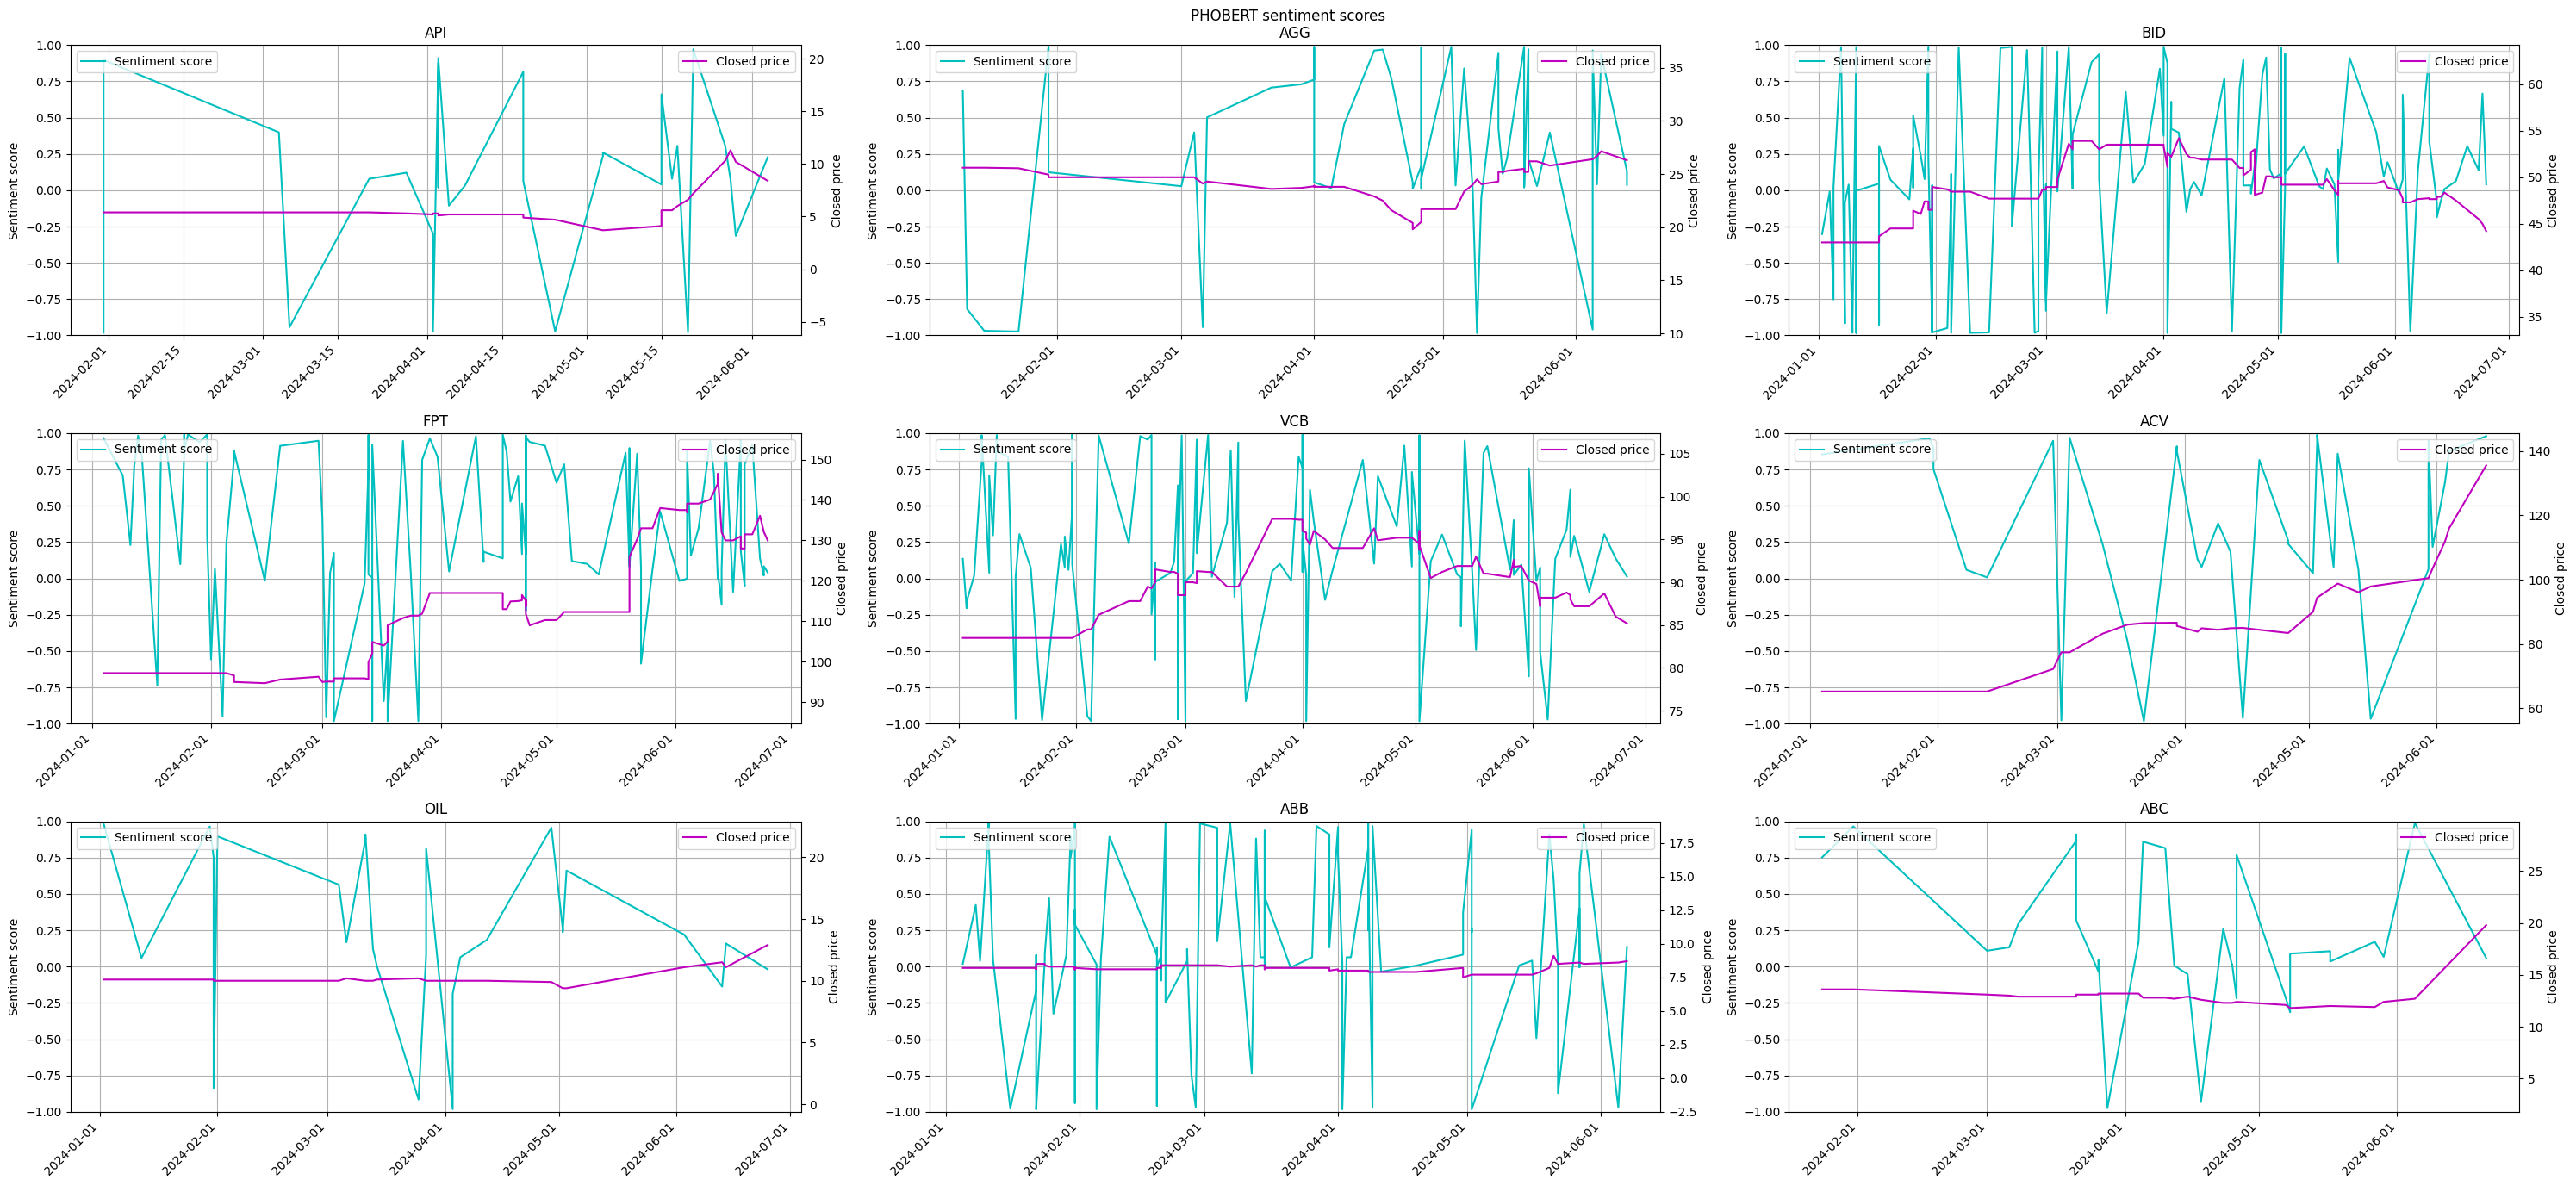

In [201]:
fig = plt.figure(figsize=(30, 14))

for company, item in company_news.items():
    date = item['timeline']
    price = item['price']
    sentiment_scores = item['sentiment']
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_title(company)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color='c', label='Sentiment score')
    ax.legend(loc='upper left')
    ax.set_ylabel('Sentiment score')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    axt = ax.twinx()
    axt.plot(dates, price, color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylabel('Closed price')

    axt.set_xlabel('Date')
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    phobert_sentiment_scores.append(sentiment_scores)

fig.suptitle('PHOBERT sentiment scores')
plt.legend()
plt.tight_layout()
plt.savefig('phobert_sentiment_scores.png')
plt.show()

### Plot volatility

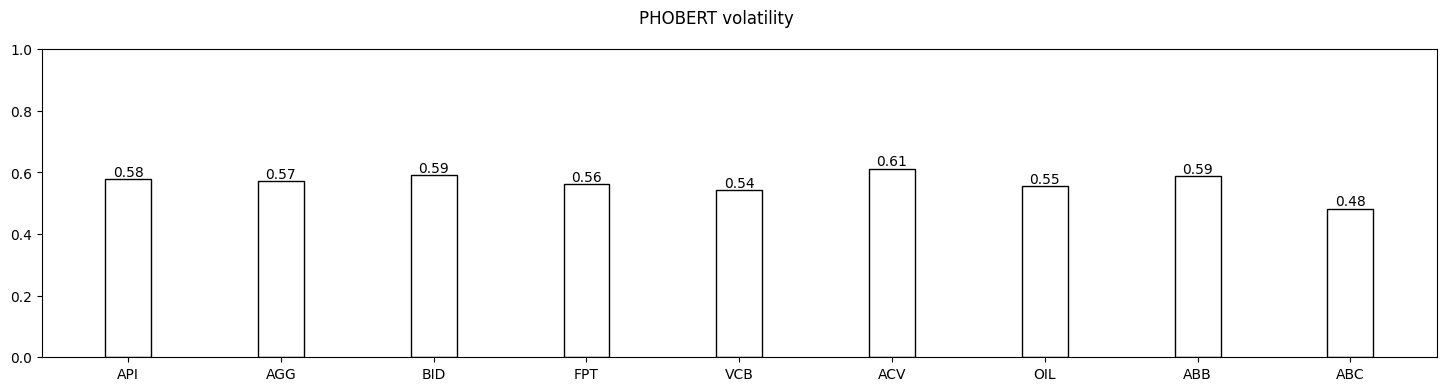

In [202]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = {}

for company, item in company_news.items():
    sentiment_scores = item['sentiment']
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(company_list.index(company), volatility, f"{volatility:.2f}", ha='center', va='bottom')

ax.bar(company_list, volatility_plot.values(), 0.3, color='w', edgecolor='k')
ax.set_ylim(0, 1)

fig.suptitle('PHOBERT volatility')
plt.savefig('phobert_volatility.png')
plt.show()

## Use ViSoBERT

### Load model

In [203]:
uit = AutoModelForSequenceClassification.from_pretrained('uitnlp/visobert')
uit_tokenizer = AutoTokenizer.from_pretrained('uitnlp/visobert')

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [204]:
start = timeit.default_timer()

sentiments = {}

for company, item in company_news.items():
    company_news[company]['sentiment'] = []
    for title in item['tokenized_news']:
        encoding = uit_tokenizer(title, return_tensors='pt')
        with torch.no_grad():
            output = uit(**encoding)
            sentiments['pos'] = round(output.logits.softmax(dim=-1).tolist()[-1][0], 3)
            sentiments['neg'] = round(output.logits.softmax(dim=-1).tolist()[-1][1], 3)
            sentiments['compound'] = round(sentiments['pos'] - sentiments['neg'], 4)
            company_news[company]['sentiment'].append(sentiments['compound'])
            print(f"{company}: {title} - {sentiments}")

stop = timeit.default_timer()

visobert_time_execution = stop - start

API: doanh_nghiệp bất_động_sản gia_tăng vay nợ đầu 2024 - {'pos': 0.541, 'neg': 0.459, 'compound': 0.082}
API: thay_đổi giấy đăng_ký kinh_doanh - {'pos': 0.543, 'neg': 0.457, 'compound': 0.086}
API: cổ_phiếu 176 1 api đặc_biệt - {'pos': 0.458, 'neg': 0.542, 'compound': -0.084}
API: cbt giải_trình cổ_phiếu api trần 5 phiên liên_tiếp - {'pos': 0.48, 'neg': 0.52, 'compound': -0.04}
API: thị_trường bất_động_sản khởi_sắc thấm kết_quả kinh_doanh quý 1 - {'pos': 0.465, 'neg': 0.535, 'compound': -0.07}
API: apec land huế lỗ 19 tỷ đồng 2023 - {'pos': 0.493, 'neg': 0.507, 'compound': -0.014}
API: cổ_phiếu apec phiên trần - {'pos': 0.419, 'neg': 0.581, 'compound': -0.162}
API: nghị_quyết hội_đồng_quản_trị - {'pos': 0.427, 'neg': 0.573, 'compound': -0.146}
API: nghị_quyết đại_hội_đồng cổ_đông thường_niên 2024 - {'pos': 0.473, 'neg': 0.527, 'compound': -0.054}
API: thông_báo bổ_nhiệm nhân_sự cán_bộ công_ty - {'pos': 0.481, 'neg': 0.519, 'compound': -0.038}
API: báo_cáo tài_chính quý 1 2024 - {'pos'

### Plot sentiment score

In [205]:
visobert_sentiment_scores = []

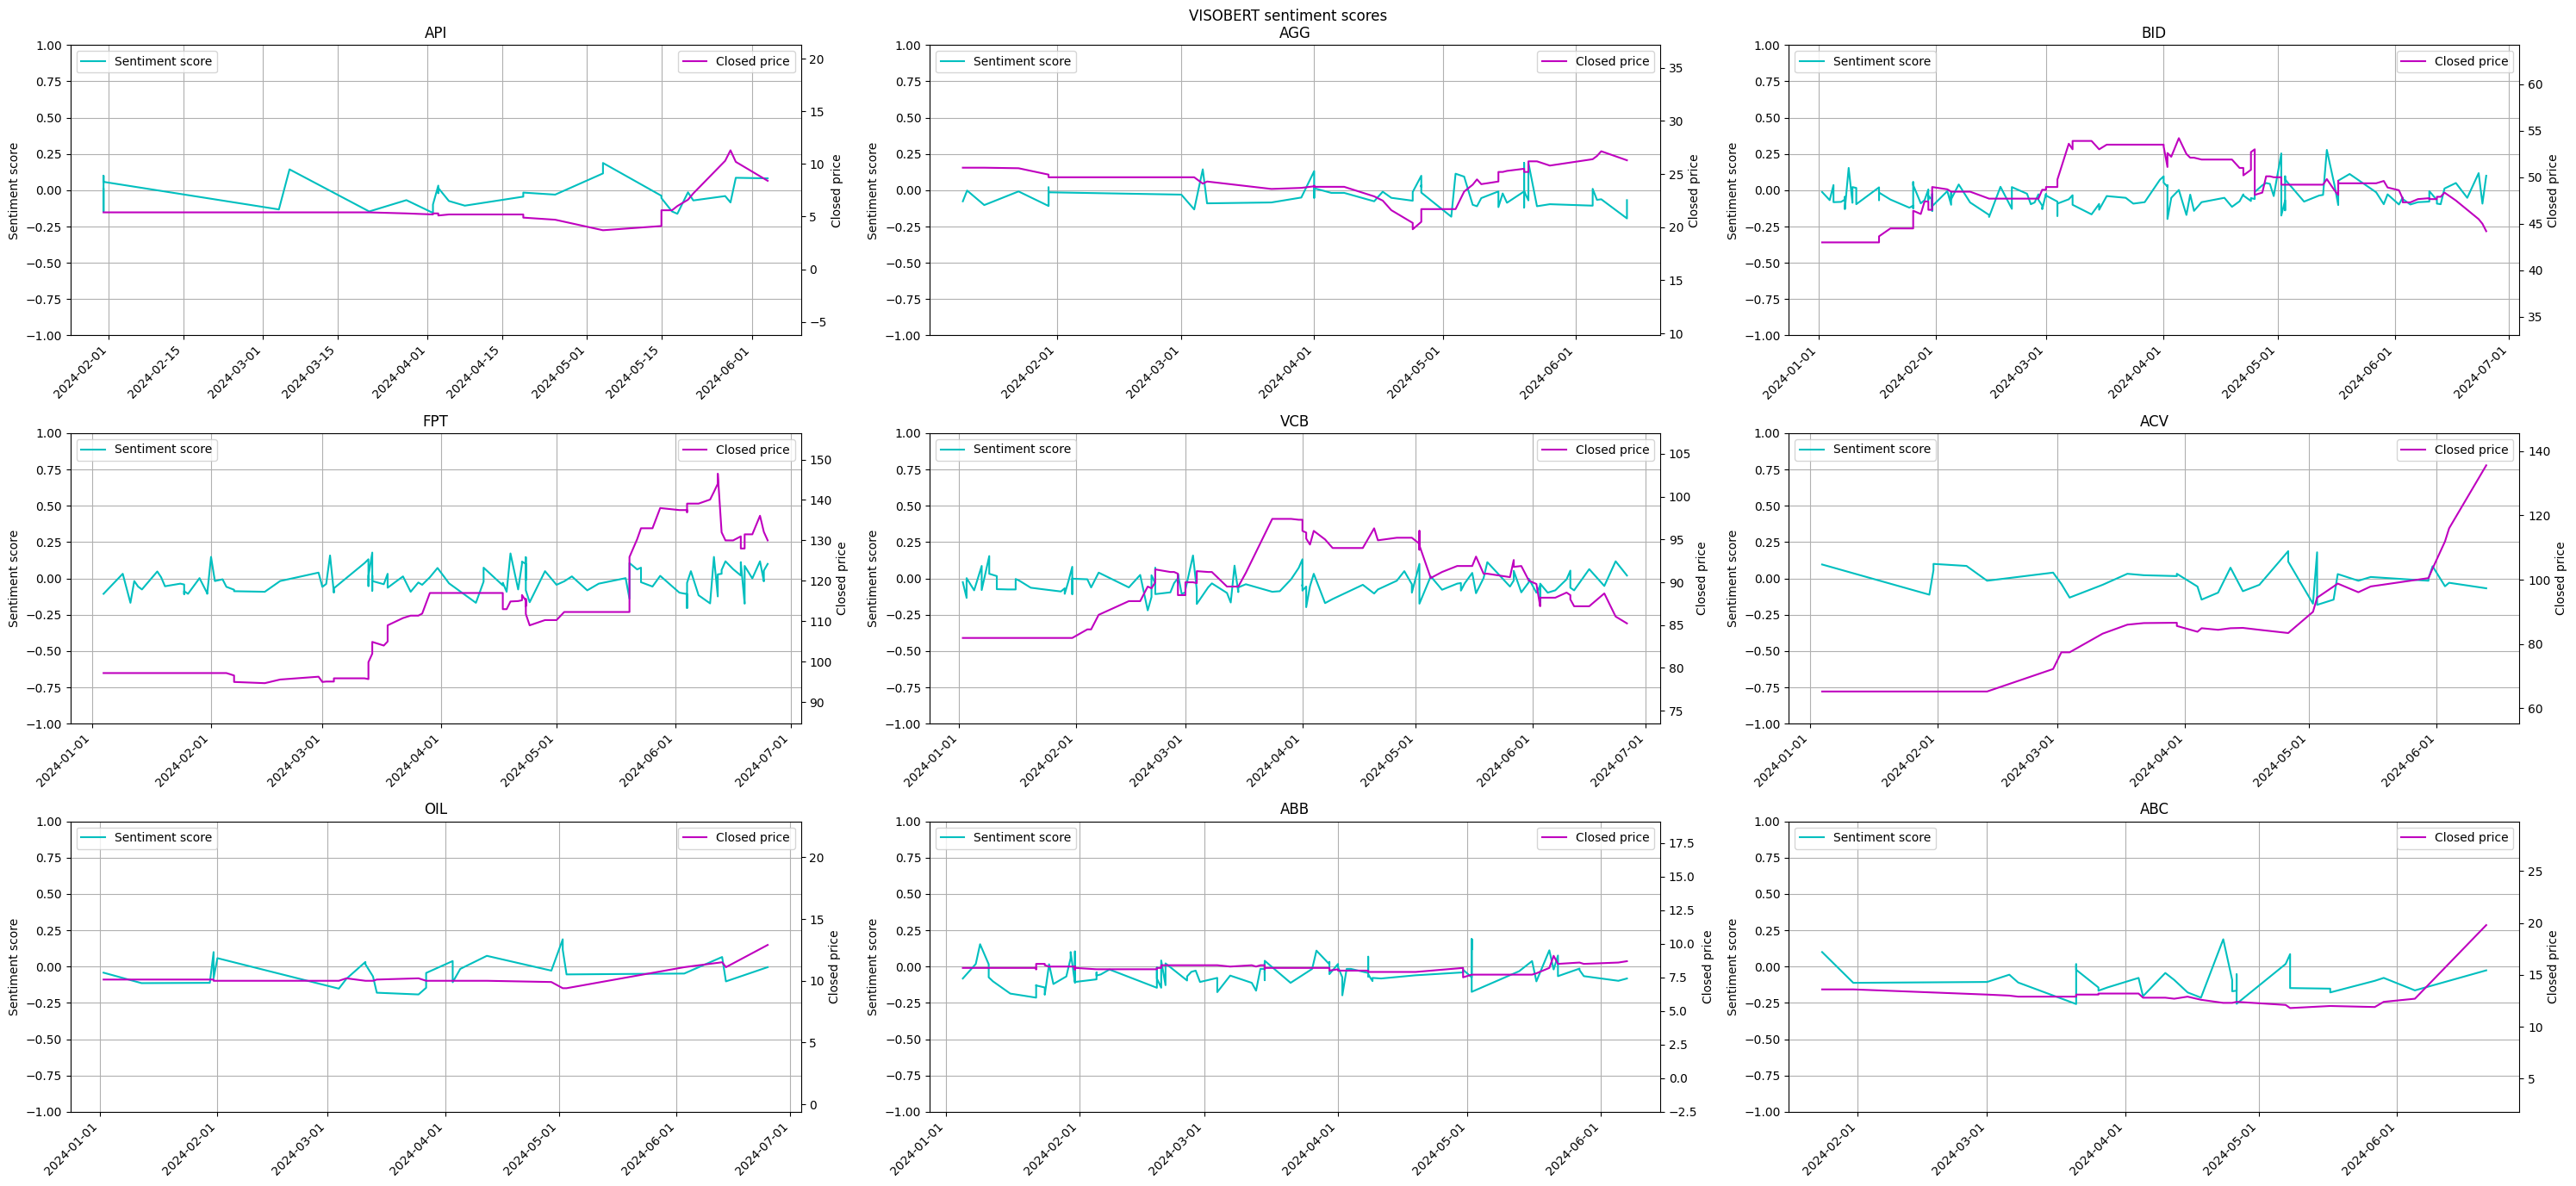

In [206]:
fig = plt.figure(figsize=(30, 14))

for company, item in company_news.items():
    date = item['timeline']
    price = item['price']
    sentiment_scores = item['sentiment']
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_title(company)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color='c', label='Sentiment score')
    ax.legend(loc='upper left')
    ax.set_ylabel('Sentiment score')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    axt = ax.twinx()
    axt.plot(dates, price, color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylabel('Closed price')

    axt.set_xlabel('Date')
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    visobert_sentiment_scores.append(sentiment_scores)

fig.suptitle('VISOBERT sentiment scores')
plt.legend()
plt.tight_layout()
plt.savefig('visobert_sentiment_scores.png')
plt.show()

### Plot volatility

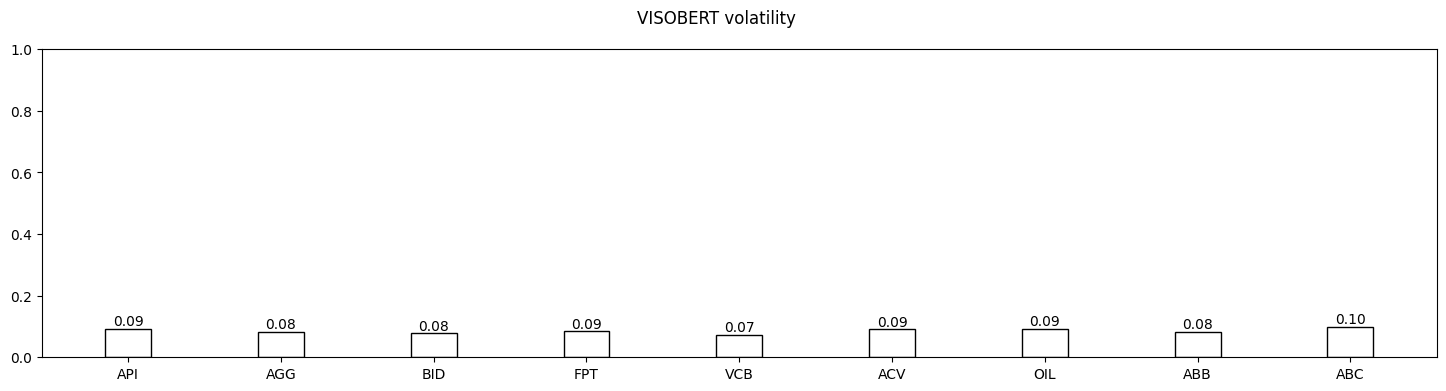

In [207]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = {}

for company, item in company_news.items():
    sentiment_scores = item['sentiment']
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(company_list.index(company), volatility, f"{volatility:.2f}", ha='center', va='bottom')

ax.bar(company_list, volatility_plot.values(), 0.3, color='w', edgecolor='k')
ax.set_ylim(0, 1)

fig.suptitle('VISOBERT volatility')
plt.savefig('visobert_volatility.png')
plt.show()

## Compare 3 models

In [208]:
sentence = 'tươi'

wonrax_sentiment = {}

input_ids = torch.tensor([wonrax_tokenizer.encode(sentence)])
with torch.no_grad():
  out = wonrax(input_ids)
  wonrax_sentiment['neg'] = round(out.logits.softmax(dim=-1).tolist()[-1][0], 3)
  wonrax_sentiment['pos'] = round(out.logits.softmax(dim=-1).tolist()[-1][1], 3)
  wonrax_sentiment['neu'] = round(out.logits.softmax(dim=-1).tolist()[-1][2], 3)
  wonrax_sentiment['compound'] = round(wonrax_sentiment['pos'] - wonrax_sentiment['neg'], 4)
  print("PHOBERT", wonrax_sentiment)

uit_sentiment = {}
encoding = uit_tokenizer(sentence, return_tensors='pt')
with torch.no_grad():
  output = uit(**encoding)
  uit_sentiment['pos'] = round(output.logits.softmax(dim=-1).tolist()[-1][0], 3)
  uit_sentiment['neg'] = round(output.logits.softmax(dim=-1).tolist()[-1][1], 3)
  uit_sentiment['compound'] = round(uit_sentiment['pos'] - uit_sentiment['neg'], 4)
  print("VISOBERT", uit_sentiment)

print("VADER", analyzer.polarity_scores(sentence))

PHOBERT {'neg': 0.001, 'pos': 0.992, 'neu': 0.007, 'compound': 0.991}
VISOBERT {'pos': 0.445, 'neg': 0.555, 'compound': -0.11}
VADER {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


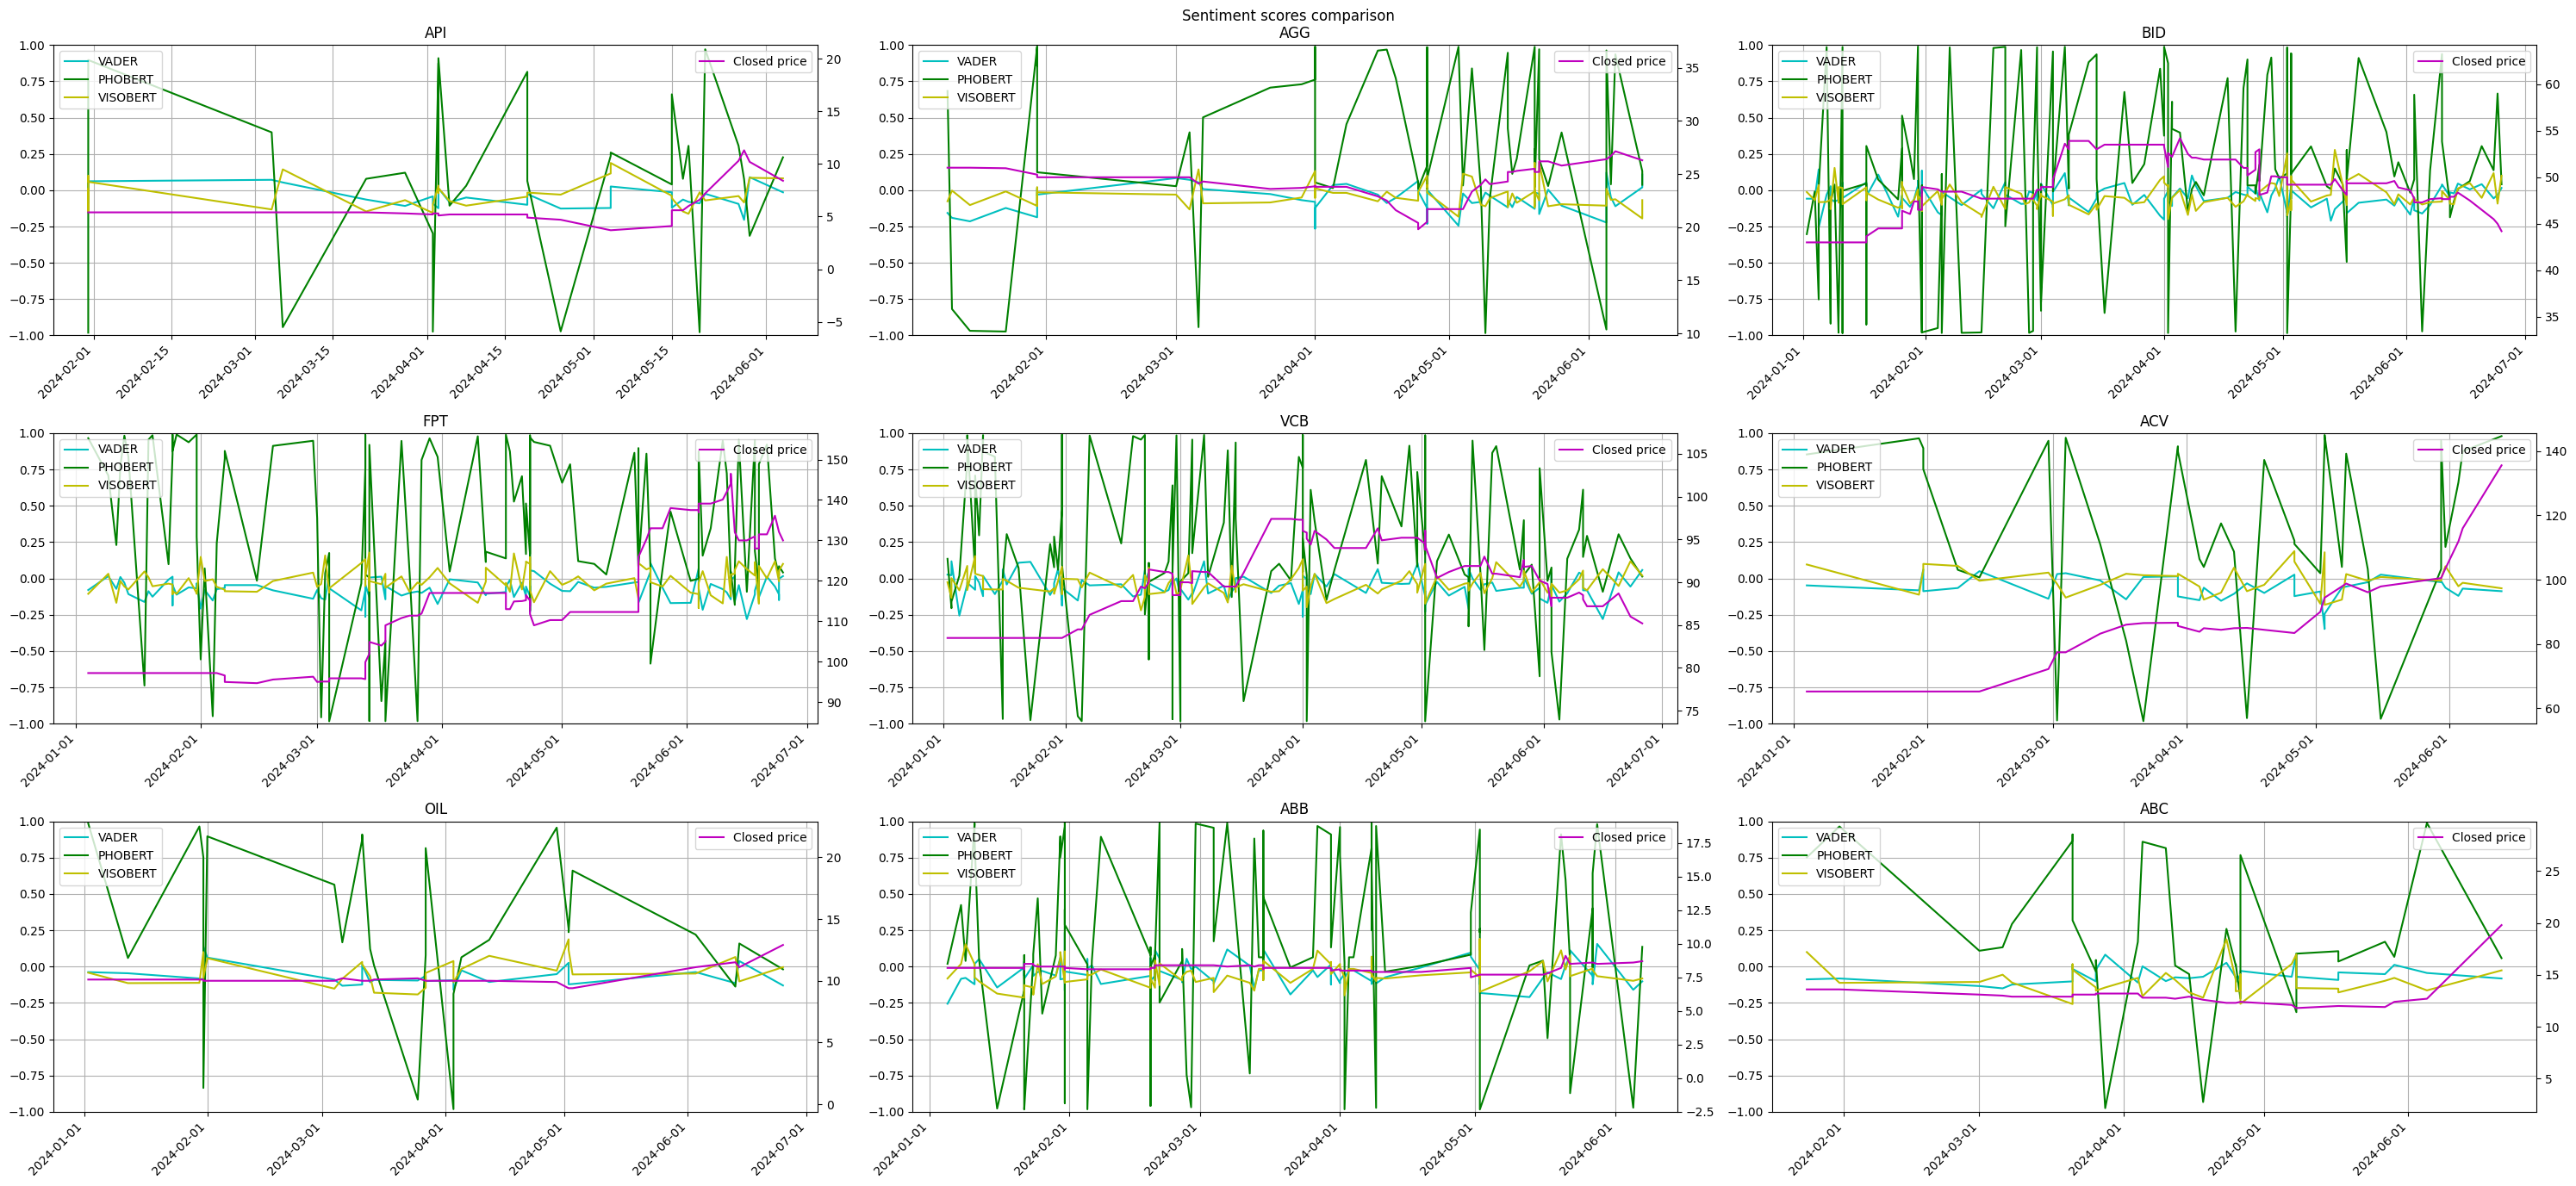

In [209]:
fig = plt.figure(figsize=(30, 14))

max_length = len(company_news[company_list[0]]['timeline'])

for idx, company in enumerate(company_list):
    date = date_time[idx]
    plot_index = idx + 1
    plot_col = 3
    plot_row = len(company_list) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_title(company)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, vader_sentiment_scores[idx], color='c', label='VADER')
    ax.plot(dates, phobert_sentiment_scores[idx], color='g', label='PHOBERT')
    ax.plot(dates, visobert_sentiment_scores[idx], color='y', label='VISOBERT')
    ax.legend(loc='upper left')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axt = ax.twinx()
    axt.plot(dates, stock_price[idx], color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylim(min(stock_price[idx]) - 10, max(stock_price[idx]) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.suptitle('Sentiment scores comparison')
plt.legend()
plt.tight_layout()
plt.savefig('compare_sentiment_scores.png')
plt.show()

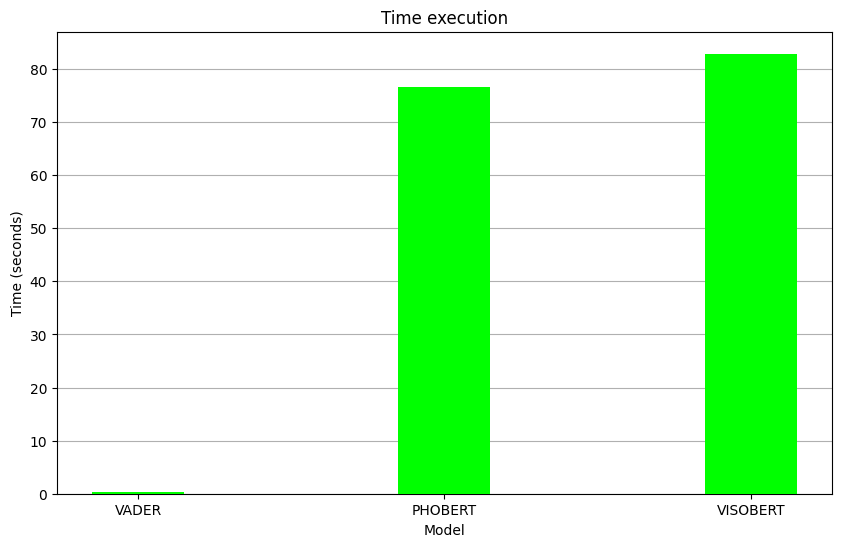

In [210]:
time_execution = {
    'VADER': vader_time_execution,
    'PHOBERT': phobert_time_execution,
    'VISOBERT': visobert_time_execution
 }

fig, ax = plt.subplots(figsize=(10, 6))
ax.yaxis.grid(zorder=0)
ax.bar(time_execution.keys(), time_execution.values(), color='lime', width=0.3, linewidth=2.5, zorder=3)
ax.set_title('Time execution')
ax.set_xlabel('Model')
ax.set_ylabel('Time (seconds)')
plt.savefig('compare_time_execution.png')
plt.show()

# Download file .png

In [212]:
# from google.colab import files
# import os

# for filename in os.listdir('/content'):
#     if filename.endswith('.png'):
#         files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>